In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr
from statsmodels.tsa.stattools import adfuller, pacf, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_white, het_breuschpagan
import numpy as np
from numpy import polyfit
from scipy import stats
import RegscorePy as rp
from numpy import sqrt
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
import itertools
import chow_test

from statistics import *
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df = pd.read_csv('./data/RTS-history-USA.csv')
series = np.array([i for i in df.Open[::25]])
series_dates = np.array([i for i in df.index[::25]])

df2 = pd.read_csv('./data/RTS-history-USA.csv', parse_dates=True, index_col='Date')
df2 = df2[::25]

In [10]:
a = Arima(series, order=(1,0,1))
f = a.fit()
f.aic, find_aic(series, f.data)

(9.776754462602838, 9.776754462602838)

### Сам график и сглаживания

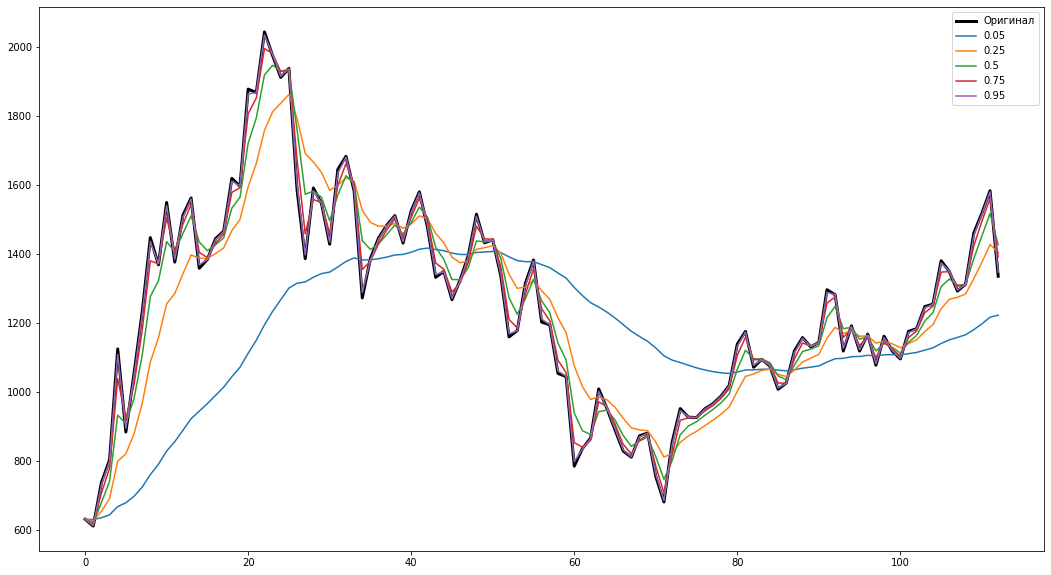

In [3]:
fig = plt.figure(figsize=(18, 10))
plt.plot(series, label='Оригинал', color='000', linewidth=3)
for a in [.05, .25, .5, .75, .95]:
    result = exponential_smoothing(series, a)
    plt.plot(result, label=str(a))
plt.legend()
plt.show()

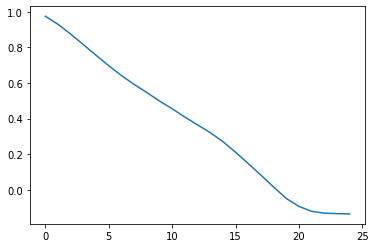

In [4]:
draw(
    find_acf(exponential_smoothing(series, .5), 1, 25)
);

### Тест фуллера на стационарность ряда

In [5]:
adfuller(series)

(-2.670316461994629,
 0.07931716496293206,
 0,
 112,
 {'1%': -3.4901313156261384,
  '5%': -2.8877122815688776,
  '10%': -2.5807296460459184},
 1212.2077258437034)

### Поиск и отображение тренда графика

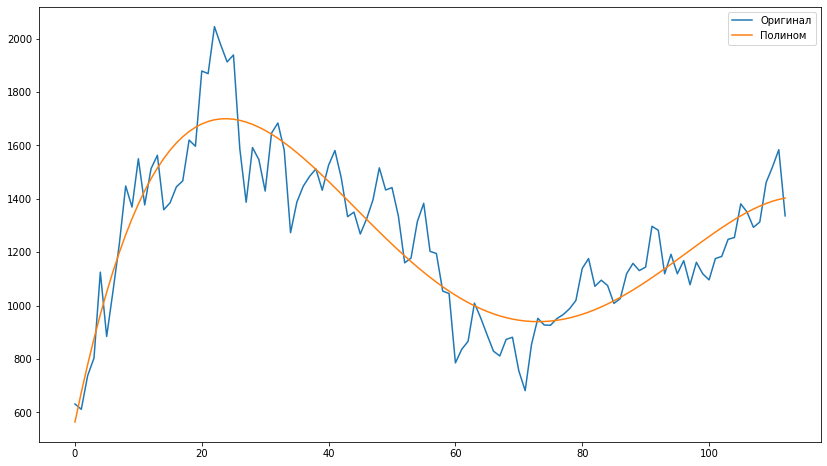

In [6]:
trend_line = find_trend_by_kf(series, 4)
fig = plt.figure(figsize=(14, 8))
draw(series, label='Оригинал')
draw(trend_line, label='Полином')
plt.legend()
plt.show()

### Расчет КФ детерминации

In [7]:
determination_kf = find_determination_kf(series, 4)
determination_kf

0.805586569565061

### Скорректированный КФ детерм

In [8]:
adjusted_determination_kf = find_adjusted_determination_kf(series, 4)
adjusted_determination_kf

0.7983860721415448

### Значимость КФ автокорреляции 2-го порядка

In [9]:
kf2 = find_acf(exponential_smoothing(series, .5), 2)
kf2 / (1-kf2**2/(len(series)-2))**.5

0.9338383925415732

### Декомпозиция

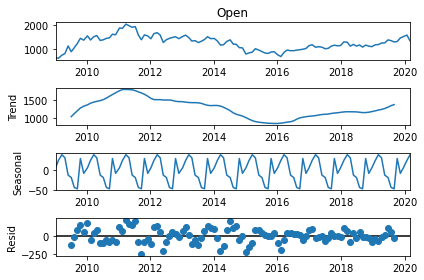

In [10]:
import statsmodels.api as sm

df2.Open.interpolate(inplace=True)

res = sm.tsa.seasonal_decompose(df2.Open, period=10)
res.plot();

### Нахождение остатков после вычитания тренда

In [11]:
remains = series - trend_line

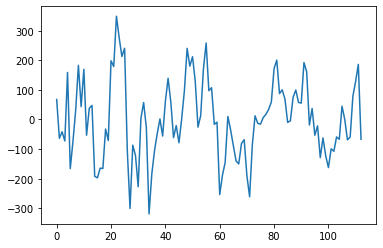

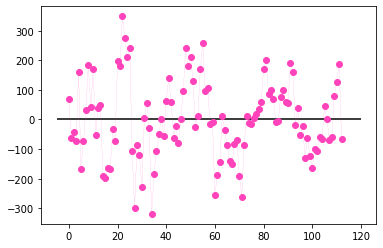

In [12]:
plt.plot(remains);
plt.show()
fig, ax = plt.subplots()
ax.plot(remains, marker='o', color='#f4b', linewidth=.1);
ax.hlines(0, -5, 120);

### Критерий Фишера для уравнения тренда 

In [13]:
(determination_kf/(1-determination_kf))*(len(series)-5)/4

111.87929419071503

## Значимость КФ регрессии по Стьюденту

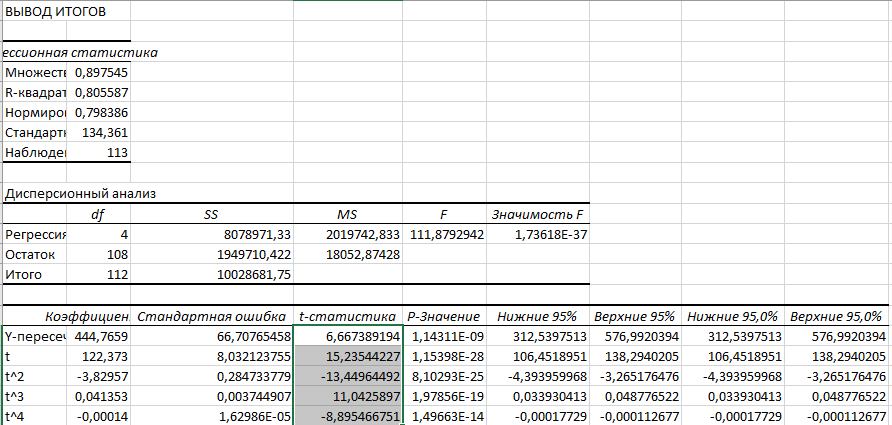

### Критерий Шварца

In [14]:
rp.bic.bic(series.tolist(), trend_line.tolist(), 5)/len(series)

9.964980051513505

In [15]:
np.log((remains ** 2).sum()/len(series))+5 * np.log(len(series))/len(series)

9.964980051513505

### Критерий Акаике

In [16]:
find_aic(series, trend_line, 5)

9.84429917457933

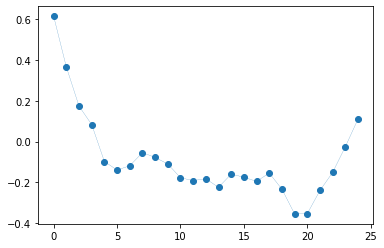

In [17]:
draw(find_acf(remains, 1, 25), marker='o', linewidth=.2);

### Критерий Жакка-Бера на нормальность распределения

In [18]:
stats.jarque_bera(remains)

(0.5095735668305718, 0.7750817406258271)

### РС критерий на нормальность распределения

In [19]:
(remains.max() - remains.min()) / ((remains**2).sum()/len(series)-1)**.5

5.085495701916399

### Тест Дарбина Уотсона на автокорреляцию

In [20]:
# Сравнить с таблицей!

In [21]:
dw = 0
for t in range(1, len(remains)):
    dw += (remains[t]-remains[t-1])**2
dw /= (remains**2).sum()
dw

0.7705080573236872

### Тест на значимость КФ автокорреляции

In [22]:
kf = find_acf(remains, 1)
sqrt((kf**2)/(1-kf**2)*(len(remains)-2))

8.193201354824389

### Тест на равенство средних

In [23]:
stats.ttest_ind(series[:60], series[60:])

Ttest_indResult(statistic=6.430267317147217, pvalue=3.3086141740613716e-09)

In [24]:
# Поскольку у нас p-value очень мало, то гипотеза h0 - о равенстве средних отвергается

In [25]:
p1 = remains[:55]
p2 = remains[55:]
abs(p1.mean() - p2.mean()) / sqrt(np.var(p1)/len(p1) + np.var(p2)/len(p2))

0.7148925714768324

### Тест на гетероскедастичность (Гольфельд Квандт)

### ARIMA

In [26]:
m, f = Arima.find_optimal_model_by_order(remains, range(7, 10), 0, (range(5, 9)))

ARIMA : 100%|██████████| 12/12 [03:48<00:00, 19.03s/ fit]


In [27]:
f.aic, f.order

(9.146757731897779, (9, 0, 7))

ARIMA : 100%|██████████| 1/1 [00:53<00:00, 53.21s/ fit]


((7, 0, 8), 9.156409597138602)

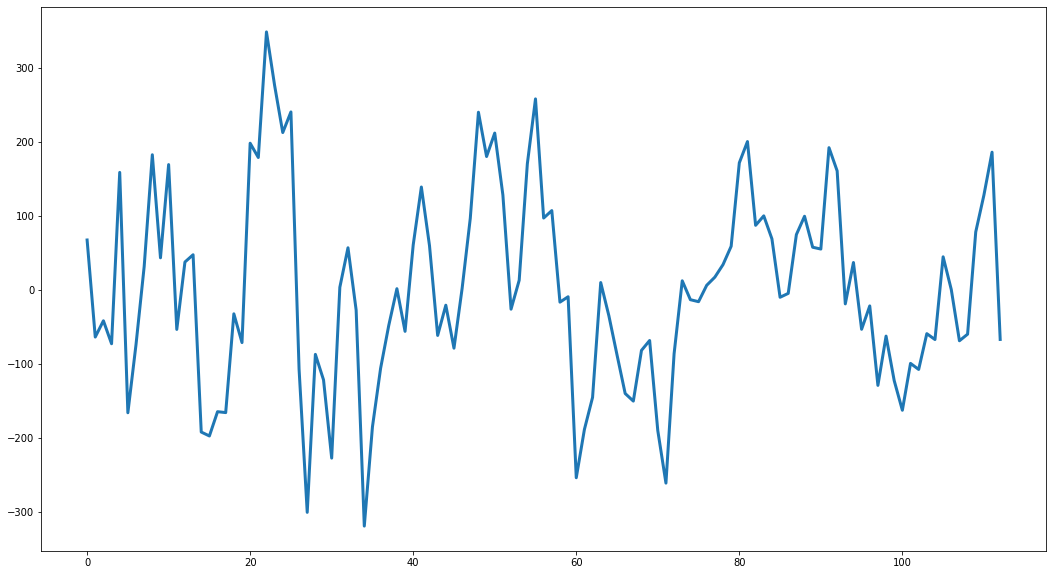

In [28]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(remains, label='Orig', linewidth=3)

# 7 0 8 - наилучшие
model, fitted_model = Arima.find_optimal_model_by_order(remains, 7, 0, 8)
fitted_model.order, fitted_model.aic

In [29]:
fitted_model.arparams

array([ 0.91147226,  0.2277196 , -0.4282041 ,  0.17270712,  0.04720058,
        0.51243451, -0.61617799])

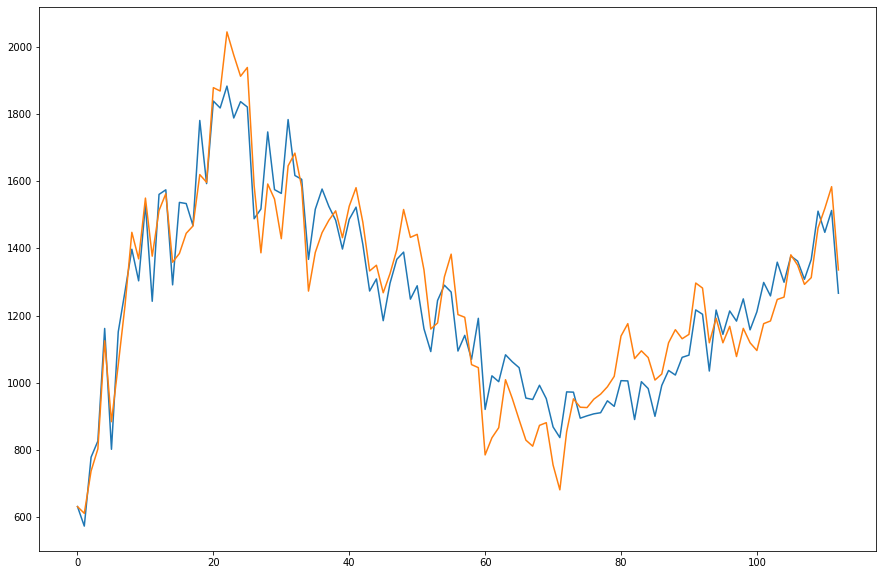

In [30]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(trend_line + fitted_model.resid)
ax.plot(series);

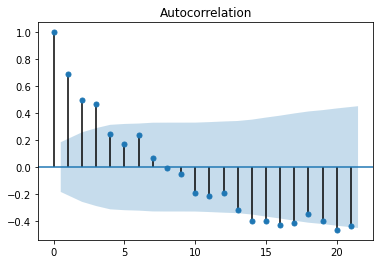

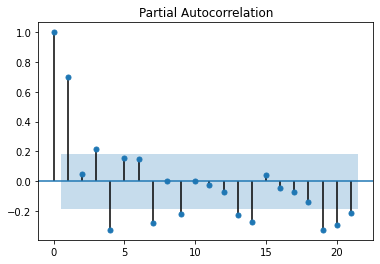

In [31]:
plot_acf(remains - fitted_model.resid)
plot_pacf(remains - fitted_model.resid);

###  Q-test Льюинга Бокса для проверки гипотезы о случайности остатков

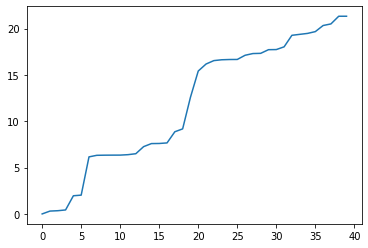

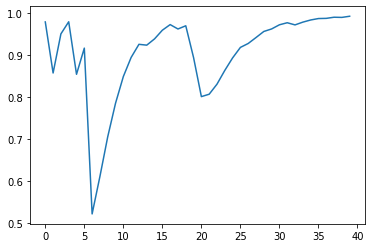

In [32]:
q_test = acf(fitted_model.resid, qstat=True, fft=False)
q_df = pd.DataFrame({'Q-stat': q_test[1], 'p-value': q_test[2]})
q_df['Q-stat'].plot()
plt.show()
q_df['p-value'].plot();

### Тест Дики Фуллера на стационарность остатков

In [33]:
test_df = adfuller(remains)
if test_df[0] > test_df[4]['5%']:
    print('Ряд нестационарен')
else:
    print('Ряд стационарен')
test_df

Ряд стационарен


(-5.130422100748794,
 1.217307664803825e-05,
 0,
 112,
 {'1%': -3.4901313156261384,
  '5%': -2.8877122815688776,
  '10%': -2.5807296460459184},
 1197.077681342571)

## Поскольку все значения p-value больше 0.05, это свидетельствует о том, что гипотеза об отсутствии автокорреляции не отвергается (на уровне значимости 5%) 

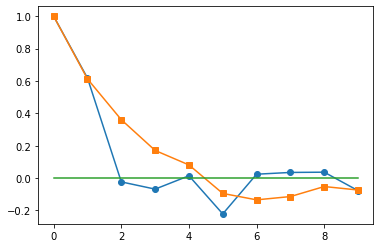

In [34]:
plt.plot(pacf(remains)[:10], marker='o', label='PACF')
plt.plot(acf(remains, fft=False)[:10], marker='s')
plt.plot([0]*10)
plt.show();

### Тесты на гомоскедантичность (p-value < 0.05 - гетероскедантичность?)

In [35]:
test_bartlett = stats.bartlett(remains, range(len(remains)))
test_levene = stats.levene(remains, range(len(remains)))
print(test_bartlett)
print(test_levene)

BartlettResult(statistic=169.41630151628857, pvalue=9.923235819367831e-39)
LeveneResult(statistic=96.43696551179367, pvalue=3.69259124387947e-19)


In [36]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  113
Model:                     ARMA(7, 8)   Log Likelihood                -669.769
Method:                       css-mle   S.D. of innovations             83.560
Date:                Tue, 10 Mar 2020   AIC                           1373.538
Time:                        17:25:43   BIC                           1419.904
Sample:                             0   HQIC                          1392.353
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1611      0.743     -0.217      0.828      -1.617       1.295
ar.L1.y        0.9115      0.140      6.509      0.000       0.637       1.186
ar.L2.y        0.2277      0.188      1.213      0.225      -0.140       0.596
ar.L3.y       -0.4282      0.131     -3.264      0.001      -0.685      -0.171
ar.L4.y        0.1727      0.156      1.106      0.269      -0.133       0.479
ar.L5.y        0.0472      0.171      0.276      0.782      -0.288       0.382
ar.L6.y        0.5124      0.139      3.699      0.000       0.241       0.784
ar.L7.y       -0.6162      0.086     -7.177      0.000      -0.784      -0.448
ma.L1.y       -0.5102      0.164     -3.106      0.002      -0.832      -0.188
ma.L2.y       -0.5246      0.133     -3.952      0.000      -0.785      -0.264
ma.L3.y        0.0106      0.090      0.118      0.906      -0.166       0.187
ma.L4.y        0.1210      0.067      1.812      0.070      -0.010       0.252
ma.L5.y       -0.2904      0.076     -3.802      0.000      -0.440      -0.141
ma.L6.y       -0.8642      0.080    -10.861      0.000      -1.020      -0.708
ma.L7.y        0.7901      0.128      6.150      0.000       0.538       1.042
ma.L8.y        0.2679      0.144      1.857      0.063      -0.015       0.551
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0002           -0.0000j            1.0002           -0.5000
AR.2           -0.6391           -0.9709j            1.1623           -0.3426
AR.3           -0.6391           +0.9709j            1.1623            0.3426
AR.4            0.5372           -0.9118j            1.0582           -0.1653
AR.5            0.5372           +0.9118j            1.0582            0.1653
AR.6            1.0178           -0.1914j            1.0356           -0.0296
AR.7            1.0178           +0.1914j            1.0356            0.0296
MA.1            1.0005           -0.0010j            1.0005           -0.0002
MA.2            1.0005           +0.0010j            1.0005            0.0002
MA.3            0.4710           -0.8821j            1.0000           -0.1719
MA.4            0.4710           +0.8821j            1.0000            0.1719
MA.5           -0.5814           -0.8136j            1.0000           -0.3487
MA.6           -0.5814           +0.8136j            1.0000            0.3487
MA.7           -1.0000           -0.0000j            1.0000           -0.5000
MA.8           -3.7295           -0.0000j            3.7295           -0.5000
-----------------------------------------------------------------------------
"""

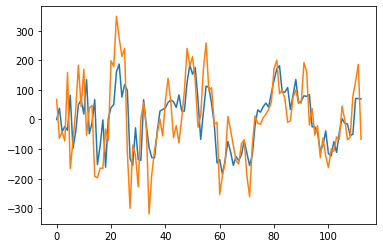

In [37]:
draw(remains - fitted_model.resid);
# plt.show()
draw(remains);

# ARIMA на исходные данные 

In [38]:
model2 = Arima(series, order=(5, 1, 6))
fitted_model2 = model2.fit()

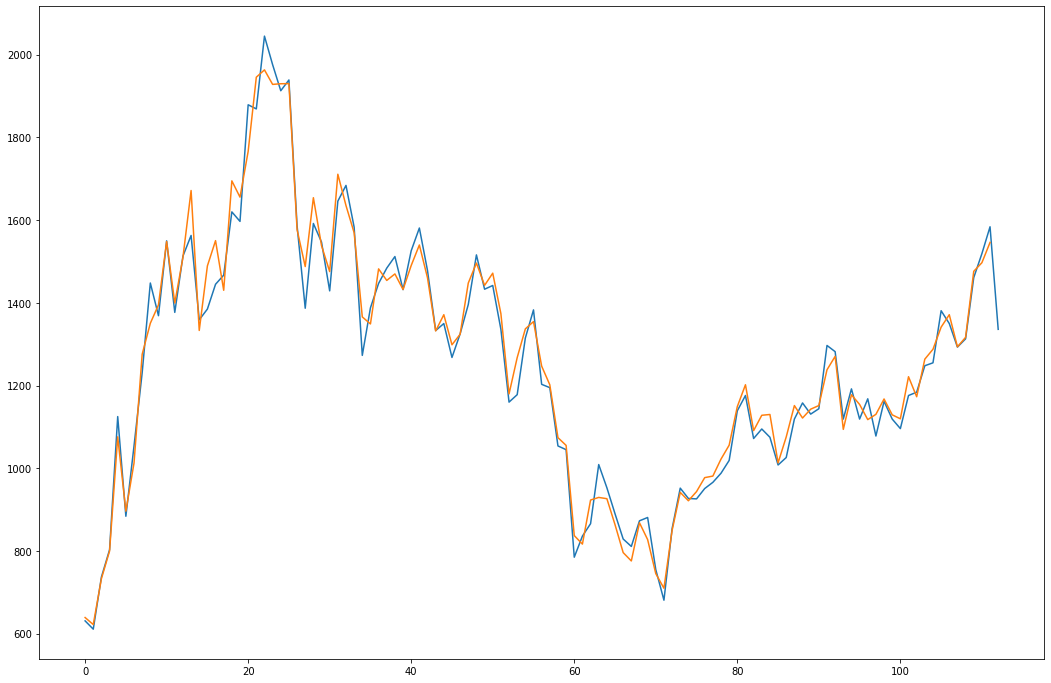

In [39]:
fig, ax = plt.subplots(figsize=(18, 12))
ax.plot(series);
ax.plot(series[1:] - fitted_model2.resid);
plt.show()

#### Остатки после тренда и остатки после аримы

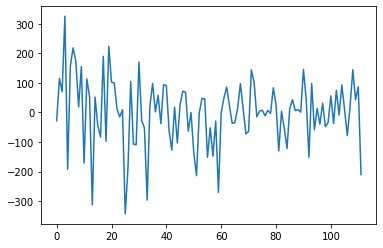

In [40]:
draw(fitted_model2.resid);

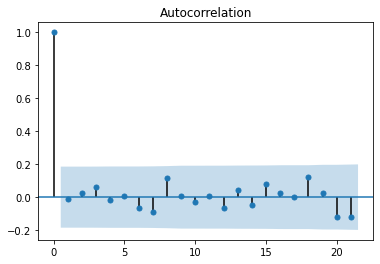

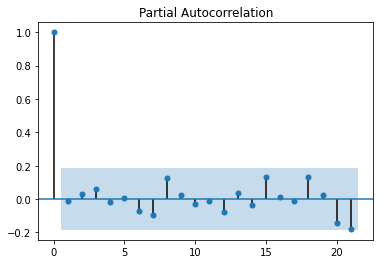

In [41]:
plot_acf(fitted_model2.resid);
plot_pacf(fitted_model2.resid);

In [42]:
# Вроде как 5 1 6 пушка акимбо 8 0 8
model3, fitted_model3 = Arima.find_optimal_model_by_order(series, range(5, 9), range(2), range(6, 9))

ARIMA : 100%|██████████| 24/24 [04:21<00:00, 10.89s/ fit]


##### Результат вроде как белый шум

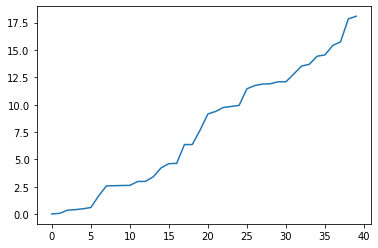

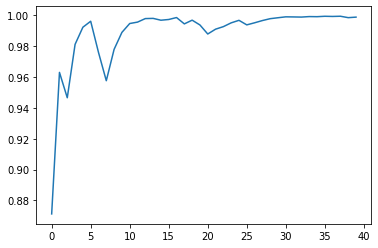

In [43]:
q_test = acf(fitted_model3.resid, qstat=True, fft=False)
q_df = pd.DataFrame({'Q-stat': q_test[1], 'p-value': q_test[2]})
q_df['Q-stat'].plot()
plt.show()
q_df['p-value'].plot();

# 3-я Глава

### Тест CHOW

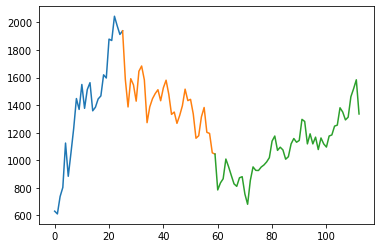

In [44]:
draw(series[:26].tolist());
draw([None]*25+series[25:60].tolist())
draw([None]*59+series[59:].tolist());

In [45]:
series1 = series[:26]

In [46]:
def find_trend_by_kf2(series, p, out=False):
    pf = np.poly1d(p)
    if out:
        print(pf(range(len(series))))
    return pf(range(len(series)))

def find_determ_kf2(seq, k):
    pl = find_trend_by_kf2(seq, get_polyfit(seq, k))
    mean = seq.mean()
    top = ((pl-mean)**2).sum()
    bottom = ((seq-mean)**2).sum()
    kf_determ = top/bottom
    return kf_determ

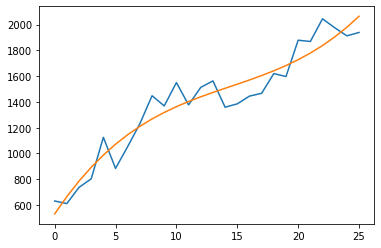

In [47]:
draw(series1);
draw(find_trend_by_kf2(series1, get_polyfit(series1, 3)));

In [48]:
find_determ_kf2(series1, 3)

0.9191035085242788

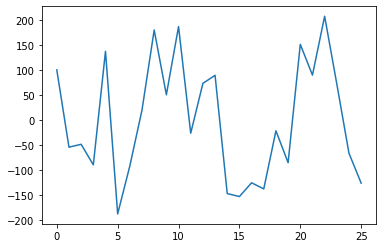

In [49]:
draw(series1 - find_trend_by_kf2(series1, get_polyfit(series1, 3)));

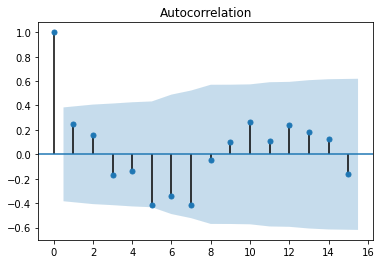

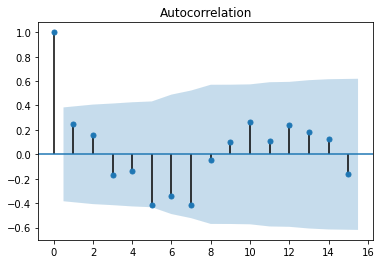

In [50]:
plot_acf(series1 - find_trend_by_kf2(series1, get_polyfit(series1, 3)))

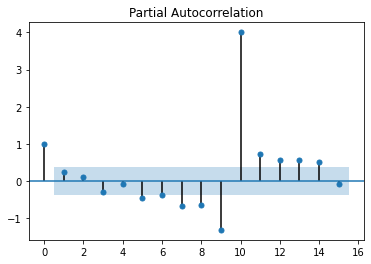

In [51]:
plot_pacf(series1 - find_trend_by_kf2(series1, get_polyfit(series1, 3)));

In [52]:
rem = series1 - find_trend_by_kf2(series1, get_polyfit(series1, 3))
for p, d, q in itertools.product((6, ), range(1), range(4, 5)):
    model = ARIMA(rem, order=(p, d, q))
    try:
        mfit = model.fit()
    except: print('Nahuy'); continue
    a = find_aic(series1[d:], series1[d:]-mfit.resid)
    print(p, d, q, a)

6 0 4 9.373008389477148


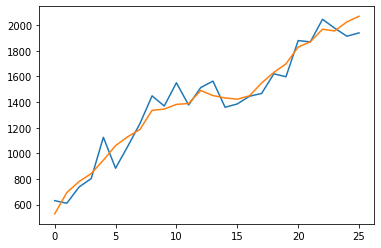

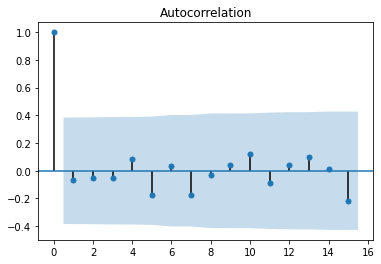

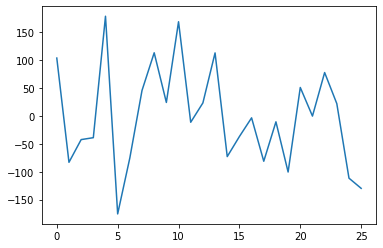

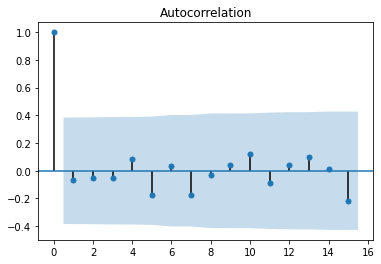

In [53]:
draw(series1)
draw(series1 - mfit.resid);
plt.show()
draw(mfit.resid);
plot_acf(mfit.resid)

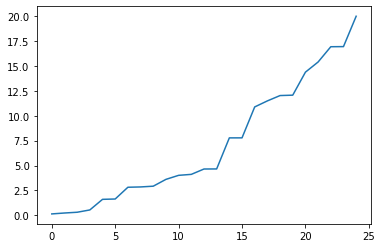

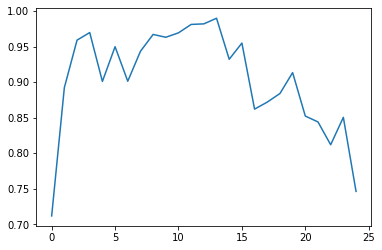

In [54]:
q_test = acf(mfit.resid, qstat=True, fft=False)
q_df = pd.DataFrame({'Q-stat': q_test[1], 'p-value': q_test[2]})
q_df['Q-stat'].plot()
plt.show()
q_df['p-value'].plot();